#Table of contents
1. [Dependency](#de)
2. [Basic Function](#bf)
3. [Config](#cfg)
4. [Data](#data)
5. [Model](#model)
6. [Deploying on Flask](#dof)
7. [Experiment](#ex)

# <a name="de">Dependency

In [ ]:
!wget https://drive.google.com/file/d/1A6uU4XdO11o_VYSV5RCGiwCb9l4Wgk4s
!pip install livelossplot
# !pip install wandb
# import wandb
# wandb.init()

In [29]:
# from livelossplot import PlotLosses
import tarfile
import os
import shutil
import random


from PIL import Image
import cv2  
import math
import re
import skimage.transform #io, transform
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import time
from tqdm import tqdm

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

seed_torch()

# from google.colab import drive
# drive.mount('/content/gdrive')
# a8356107

# <a name="bf">Basic Function

In [ ]:
def get_file_paths(folder_path):
    return [os.path.join(root, file) for root, _, files in os.walk(folder_path) for file in files] 

def get_sorted_file_paths(folder_path):
    sorted_paths = get_file_paths(folder_path)
    sorted_paths.sort(key=lambda x: list(map(int, re.findall('\d+', x))))
    return sorted_paths

def tar_file(file_path):
    start = time.time()
    with tarfile.open(file_path) as file:
        file.extractall(os.path.dirname(file_path),)
        print(f'done! time: {time.time() - start}')

def get_data(file_path, dtype="normal"):
    with open(file_path) as file:
        if dtype == "normal":
            output = [elem.strip() for elem in file.readlines()]
        elif dtype == "numpy":
            output = np.fromfile(file)
        else:
            raise ValueError("arg should be either normal or numpy")
    return output

def get_total_frame_num_of_target_video(index):
    return (len(list(os.walk(f'/content/aff_wild_annotations_bboxes_landmarks_new/landmarks/train/{index}/'))[0][2]),
            len(list(os.walk(f'/content/aff_wild_annotations_bboxes_landmarks_new/bboxes/train/{index}/'))[0][2]))

def get_video_frame_indices_from_target_folder(folder_path):
    paths = get_sorted_file_paths(folder_path)
    regex = re.compile('\d+')
    indices = [regex.findall(path) for path in paths]
    return np.array(indices) # video, frame

def show_landmark_and_bbox(image, landmarks, bboxes):
    """
    Show image with landmarks
    landmarks: N images * (x, y)
    """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    for i in range(4):
        if i<3:
            plt.plot([bboxes[i][0], bboxes[i+1][0]], [bboxes[i][1], bboxes[i+1][1]])
        else:
            plt.plot([bboxes[i][0], bboxes[0][0]], [bboxes[i][1], bboxes[0][1]])
    plt.pause(0.001)  # pause a bit so that plots are updated
    
#images
def read_target_frame(video_path, frame_idx):
    cap = cv2.VideoCapture(video_path)   # capturing the video from the given path
    cap.set(1, frame_idx) #current frame number
    success, frame = cap.read()
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if success else np.zeros((224,224,3), dtype=np.uint8)
    cap.release()
    return rgb_img

def show_first_N_frame_of_target_video(video_path, pic_nums):
    cap = cv2.VideoCapture(video_path)   # capturing the video from the given path
    frame_rate = cap.get(5)
    success, frame = cap.read()
    count = 0
    while cap.isOpened() and count < pic_nums:
        if not success:
            break
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        show_image(rgb_img)
        cap.set(1, cap.get(1)+frame_rate) #current frame number
        count += 1        
    cap.release()

def save_video_frames_to_target_folder(video_path, target_folder_path, frame_rate=100):
    cap = cv2.VideoCapture(video_path)   # capturing the video from the given path
    video_index = re.search('\d+',video_path).group()
    print("Video Index: ", video_index)
    success, frame = cap.read()
    if os.path.exists(target_folder_path):
        os.chdir(target_folder_path)
    else:
        os.mkdir(target_folder_path)
    current_frame_num = cap.get(1)
    total_frame_num = cap.get(7)
    while cap.isOpened() and current_frame_num < total_frame_num - 50: # do not use final 50 frames
        if not success:
            break
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cap.set(1, cap.get(1)+frame_rate) #current frame number
        cv2.imwrite(f'video{video_index}frame{current_frame_num}.jpg', rgb_img)
    cap.release()
    print(f'{video_index} video done!')


# def torchvision_read_video(path):
#     """package問題"""
#     torchvision.io.read_video(path)

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        print(s)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

def remove_folder(path):
    shutil.rmtree(path)


# raw_data_handler
def get_raw_data():
    """
    Time Cost
        2'30 downloaded
        2'00 tar .tar.gz
        10'20 tar whole file 54s faster than no mp version
    """
    from google.colab import drive
    drive.mount('/content/gdrive')    
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import multiprocessing

    # downloading
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    print('start downloading!')
    start = time.time()
    downloaded = drive.CreateFile({'id':"1A6uU4XdO11o_VYSV5RCGiwCb9l4Wgk4s"}) 
    downloaded.GetContentFile('aff_wild_videos_annotations_bboxes_landmarks.tar.gz')
    downloaded.Upload()
    print(f'download done, time: {time.time()-start}')

    # taring
    print('start taring!')
    tar_file('/content/aff_wild_videos_annotations_bboxes_landmarks.tar.gz')

    tarfile_paths = get_file_paths('/content/aff_wild_annotations_bboxes_landmarks_new')
    manager = multiprocessing.Manager()
    jobs = []
    print(f'total tarfiles: {len(tarfile_paths)}\nstart taring...')
    for i, path in enumerate(tarfile_paths):
        p = multiprocessing.Process(target=tar_file, args=(path, i))
        jobs.append(p)
        p.start()
            
    for proc in jobs:
        proc.join()

def data_prep():
    """
    Time Cost
        4'?? move
        11'14 tar
    """
    src = '/content/gdrive/MyDrive/SideProject/aff_wild_annotations_bboxes_landmarks_new'
    dst = '/content/aff_wild_annotations_bboxes_landmarks_new'
    try:
        copytree(src, dst)
    except:
        pass

    # 解壓縮
    tarfile_paths = get_file_paths('/content/aff_wild_annotations_bboxes_landmarks_new')
    for path in tarfile_paths:
            tar_file(path)




In [ ]:

get_raw_data() 

224


# <a name="cfg">Config

In [31]:
# setting
class dconfig:
    root_folder = '/content/aff_wild_annotations_bboxes_landmarks_new'
    batch_size = 64 # batch size
    use_gpu = True # use GPU or not
    num_workers = 2 # how many workers for loading data
    pin_memory = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    frame_rate = 100
    is_landmark_required = True

class mconfig:
    model_root_folder = '/content/gdrive/MyDrive/SideProject/model/'
    loss_graph_root_folder = '/content/gdrive/MyDrive/SideProject/loss_graph/'
    
    model_name = 'res34_bsize64_adam'
    is_continued_training = False
    target_epoch_folder_name = 'epoch12' # needed only when loading model
    resnet_size = 34
    is_pretrained = True
    target_class_num = 2 # arousal and valence

    print_freq = 20 # print info every N batch
    save_freq = 4 # save model every N epoch
    max_epoch = 20
    lr = 0.001 # initial learning rate
    lr_decay = 0.95 # when val_loss increase, lr = lr * lr_decay
    weight_decay = 1e-4 # 损失函数

    model_save_folder = os.path.join(model_root_folder, model_name)
    target_model_path = os.path.join(model_save_folder , target_epoch_folder_name)
    loss_graph_folder_path = os.path.join(loss_graph_root_folder, model_name)

# <a name="data">Data

## easy Label EDA

In [ ]:
root_folder = "/content/aff_wild_annotations_bboxes_landmarks_new"
box_folder = os.path.join(root_folder, "bboxes/train")
landmark_folder = os.path.join(root_folder, "landmarks/train")

box_indices = get_video_frame_indices_from_target_folder(box_folder)
lm_indices = get_video_frame_indices_from_target_folder(landmark_folder)

print(
f'box and landmark folder have the same indices: \
{(box_indices == lm_indices).all()}\n\
total frames with box and landmark: {box_indices.shape[0]}'
)

sorted_annot_paths = get_sorted_file_paths(os.path.join(root_folder, 'annotations/train'))
annotations_a = [get_data(path) for path in sorted_annot_paths[::2]]
annotations_v = [get_data(path) for path in sorted_annot_paths[1::2]]

annotations = np.array([[re.search('\d+', sorted_annot_paths[::2][num]).group(), frmidx, annotations_v[num][frmidx], annotations_a[num][frmidx]] 
                    for num, frames in enumerate(annotations_a) 
                    for frmidx in range(len(frames))]) 

df_annote = pd.DataFrame(annotations, columns=['vid_idx', 'frm_idx', 'v', 'a'])
df_box = pd.DataFrame(box_indices, columns=['vid_idx', 'frm_idx'])

df_with_boxlm = df_box.merge(df_annote, on=['vid_idx', 'frm_idx'])

df_zero = df_with_boxlm[(df_with_boxlm['a'] == '0.0') & (df_with_boxlm['v'] == '0.0')]
df_zero = df_zero.astype(float)

print("Annotations Stastics:")
df_annote[['v', 'a']].describe()

plt.scatter(x=df_zero['vid_idx'], y=df_zero['frm_idx'])
plt.title('scatter plot of video index vs frame index that v, a\'s value equals to zero')
plt.show()

df_nonzero = df_with_boxlm[(df_annote['a'] != '0.0') & (df_with_boxlm['v'] != '0.0')]
df_nonzero = df_with_boxlm.astype(float)

plt.scatter(x=df_nonzero['v'], y=df_nonzero['a'])
plt.title('scatter of not zero value, imbalanced')
plt.show()

NameError: ignored

## DATASET

In [32]:
# custom data loader
# from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, root_folder=dconfig.root_folder, transform=None, phase='train', frame_rate=dconfig.frame_rate, is_landmark_required=dconfig.is_landmark_required):
        """
        Keyword Args:
            phase: str, train or valid or test
        """           
        self.root_folder = root_folder
        self.frame_rate = frame_rate if phase == 'train' else frame_rate*2 
        self.transform = transform
        self._phase = phase
        self._is_landmark_required = is_landmark_required

        self.annotations = self._get_annotations()
        self._len = self.annotations.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        assert isinstance(idx, (int, list)), '必須是int or list'

        image_index = int(self.annotations[idx][0])
        frame_index = int(self.annotations[idx][1])
        sub_file_name = '.avi' if image_index <= 200 else '.mp4'
        
        image_path = os.path.join(self.root_folder, f'videos/train/{image_index}{sub_file_name}')
        bbox_file_path = os.path.join(self.root_folder, f'bboxes/train/{image_index}/{frame_index}.pts')
        landmark_file_path = os.path.join(self.root_folder, f'landmarks/train/{image_index}/{frame_index}.pts')
        
        image = read_target_frame(image_path, frame_index)
        sample = {
            'image': image,
            'annotations': self.annotations[idx][2:],
            'bboxes': self.get_bboxes_or_landmarks(bbox_file_path) if os.path.exists(bbox_file_path) else np.zeros((4,2), dtype=np.int8),
            'landmarks': self.get_bboxes_or_landmarks(landmark_file_path) if os.path.exists(landmark_file_path) and self._is_landmark_required else np.zeros((68,2), dtype=np.int8)
        } if image.mean() > 30 else { # black image filtered
            'image': image,
            'annotations': np.zeros((2), dtype=np.int8),
            'bboxes': np.zeros((4, 2), dtype=np.int8),
            'landmarks': np.zeros((68, 2), dtype=np.int8)
        }
        if self.transform:      
            sample = self.transform(sample)
        return sample


    def _get_annotations(self):
        """Get annotation data as the folloing form:
        annotations: np.array, [video_index, frame_index, velance, arousal]
        """

        sorted_annot_paths = get_sorted_file_paths(os.path.join(self.root_folder, 'annotations/train'))
        if self.phase == 'train':
            sorted_annot_paths = sorted_annot_paths[:370] 
        elif self.phase == 'test':
            sorted_annot_paths = sorted_annot_paths[12:14]
        else: 
            sorted_annot_paths = sorted_annot_paths[370:]

        annotations_a = [get_data(path) for path in sorted_annot_paths[::2]]
        annotations_v = [get_data(path) for path in sorted_annot_paths[1::2]]

        annotations = np.array([[re.search('\d+', sorted_annot_paths[::2][num]).group(), frmidx, annotations_v[num][frmidx], annotations_a[num][frmidx]] 
                                for num, img in enumerate(annotations_a) 
                                for frmidx in range(50, len(img)-50)], dtype=np.float16) #-50代表後50個frame不取
        
        annotations = annotations[(annotations[:,2:] != 0).any(axis = 1)] # 篩選掉 valence and arousal == 0
        return annotations[::self.frame_rate] #以self.frame_rate 取樣

    def get_bboxes_or_landmarks(self, path):
        data = [elem.split(' ') for elem in get_data(path)[3:-1]]
        return np.array(data).astype(np.float16)


# from torchvision import transforms, utils
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)), '必須是 int or tuple'
        self.output_size = output_size
    
    def __call__(self, sample):
        image, bboxes, landmarks = sample['image'], sample['bboxes'], sample['landmarks']
        if image.mean() == 0: #讀取影片失敗會得到 np.zeros((224, 224, 3))
            pass
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = int(h * self.output_size / w), self.output_size
            else:
                new_h, new_w = self.output_size, int(w * self.output_size / h)
        else:
            new_h, new_w = self.output_size
        
        image = cv2.resize(image, dsize=(new_w, new_h))
        if (landmarks[0]!=0).any():
            landmarks = (landmarks * [new_w/w, new_h/h]).astype(np.int16)
        if (bboxes[0]!=0).any():
            bboxes = (bboxes * [new_w/w, new_h/h]).astype(np.int16)
        return {
            'image': image,
            'annotations': sample['annotations'],
            'bboxes': bboxes,
            'landmarks': landmarks
            }

class TargetRandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bboxes, landmarks, annotations = sample['image'], sample['bboxes'], sample['landmarks'], sample['annotations']
        if image.mean() == 0: #讀取影片失敗會得到 np.zeros((224, 224, 3))
            pass
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        max_left = w - new_w
        max_top = h - new_h
        
        if (bboxes[0]!=0).any():
            box_left, box_top = bboxes[0]
            if box_left < max_left:
                max_left = box_left
            if box_top < max_top:
                max_top = box_top
            left = np.random.randint(max_left*0.65, max_left+1)
            top = np.random.randint(max_top*0.65, max_top+1)
            bboxes = bboxes - [left, top]

        else:
            top = max_top
            left = max_left
           
        image = image[top: top + new_h,
                        left: left + new_w]
        
        if (landmarks[0]!=0).any():
            landmarks = landmarks - [left, top]

        return {
            'image': image,
            'annotations': annotations,
            'bboxes': bboxes,
            'landmarks': landmarks
            }


class ToTensor(object):
    def __call__(self, sample):
        image, bboxes, landmarks, annotations = sample['image'], sample['bboxes'], sample['landmarks'], sample['annotations']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float()/255.0,
                'annotations': torch.from_numpy(annotations).float(),
                'bboxes': torch.from_numpy(bboxes).float(),
                'landmarks': torch.from_numpy(landmarks).float()
                }

def get_dataset_dataloader(phase):
    shuffle_dict = { 'train': True, 
                    'valid': False, 
                    'small': False }

    composed_transforms = transforms.Compose([
                                          Rescale(280),
                                          TargetRandomCrop(224),
                                          ToTensor()
                                        ])
    dataset = CustomDataset(transform=composed_transforms, phase=phase)
    dataloader = DataLoader(
        dataset,
        batch_size = dconfig.batch_size,
        shuffle = shuffle_dict[phase],
        num_workers = dconfig.num_workers,
        pin_memory = dconfig.pin_memory
    )
    return dataset, dataloader

In [ ]:
# train_dataset, train_dataloader = get_dataset_dataloader('train')
# valid_dataset, valid_dataloader = get_dataset_dataloader('valid')

# for ds in [train_dataset, valid_dataset]:
#     print(len(ds))

7558
1083


# <a name="model">MODEL

1. super是必須的, 不然會出錯

In [ ]:
#save_and_load_model
def save_loss_as_txt(loss_dict, folder_path):
    """
    loss_dict: {'train': [], 'valid': [], epoch: [], time: []}
    """
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    file_path = os.path.join(folder_path, mconfig.model_name + '.txt')
    with open(file_path, 'a+') as file:
        file.write('epoch, train loss, valid loss, time\n')
        for t, v, e, time in zip(loss_dict['train'], loss_dict['valid'], loss_dict['epoch'], loss_dict['time']):
            file.write(f'{e}, {t}, {v}, {time}\n')

def save_model(PATH):
    torch.save(model.state_dict(), PATH)

def load_model(PATH):
    model.load_state_dict(torch.load(PATH))
    model.eval()

def save_general_checkpoint(PATH, epoch):
    folder_path = os.path.dirname(PATH)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.cpu().state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,            
            }, PATH)

def load_general_checkpoint(PATH):
    checkpoint = torch.load(PATH, map_location=dconfig.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(dconfig.device)
    for model_params, optim_params in optimizer.state.items():
        for k, v in optim_params.items():
            if isinstance(v, torch.Tensor):
                optim_params[k] = v.to(dconfig.device)

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    # model.eval()
    model.train()
    return model, optimizer, epoch, loss


def make_model(mconfig.resnet_size, is_pretrained=mconfig.is_pretrained):
    model_dict = {18: models.resnet18,
                  34: models.resnet34,
                  50: models.resnet50,
                  101: models.resnet101,
                  152: models.resnet152 }
    model = model_dict[model_size](pretrained=is_pretrained)
    num_fts = model.fc.in_features
    if is_pretrained:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(num_fts, mconfig.target_class_num)
    
    return model

In [ ]:
train_dataset, train_dataloader = get_dataset_dataloader('train')
valid_dataset, valid_dataloader = get_dataset_dataloader('valid')
model = make_model()
loss = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=mconfig.lr)
writer = SummaryWriter(log_dir=mconfig.loss_graph_folder_path, filename_suffix=mconfig.model_name)
plotlosses = PlotLosses()
start_epoch = 0
if mconfig.is_continued_training:
    model, optimizer, start_epoch, loss = load_general_checkpoint(mconfig.target_model_path)

In [ ]:
def train_model(train_iter, valid_iter, model, loss, optimizer, start_epoch):
    model.to(dconfig.device).float()
    loss_dict = {'train': [], 'valid': [], 'epoch': [], 'time': []}

    for epoch in range(mconfig.max_epoch):
        start = time.time()
        now_epoch = epoch + start_epoch

        for phase, data_iter in [('train', train_iter), ('valid', valid_iter)]:
            l, epoch_loss, n, batch_count = 0.0, 0.0, 0, 0
            print(f'{phase}{now_epoch} start!')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            for sample in data_iter:
                X, y = sample['image'].float().to(dconfig.device), sample['annotations'].float().to(dconfig.device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    y_hat = model(X)
                    l = loss(y_hat, y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l.backward()
                        optimizer.step()

                epoch_loss += l.detach().cpu().item()
                n += dconfig.batch_size
                batch_count += 1 

                if batch_count % mconfig.print_freq == 0:
                    print(f'{batch_count} batch, time: {time.time() - start}')

            epoch_loss = epoch_loss * n / batch_count
            loss_dict[phase].append(epoch_loss)
                

        loss_dict['epoch'].append(now_epoch)
        loss_dict['time'].append(time.time() - start)
        writer.add_scalar(mconfig.model_name+"_Loss/train", loss_dict['train'][-1], now_epoch)
        writer.add_scalar(mconfig.model_name+"_Loss/valid", loss_dict['valid'][-1], now_epoch)
        writer.flush()

        plotlosses.update({'loss': loss_dict['train'][-1], 'val_loss': loss_dict['valid'][-1]})        
        plotlosses.send()
        
        print(f'epoch: {now_epoch}, train_loss: {loss_dict["train"][-1]:.4f}, test_loss: {loss_dict["valid"][-1]:.4f}, epoch_time: {time.time() - start:.1f} sec')
        
        if now_epoch % mconfig.save_freq == 0:
            filename =  'epoch' + str(now_epoch)
            PATH = os.path.join(mconfig.model_save_folder, filename)
            save_general_checkpoint(PATH, now_epoch)
            save_loss_as_txt(loss_dict, mconfig.model_save_folder)
            model.to(dconfig.device)
            loss_dict = {'train': [], 'valid': [], 'epoch': [], 'time': []}

In [ ]:
print(train_dataloader.batch_size, optimizer, loss)
train_model(train_dataloader, valid_dataloader, model, loss, optimizer, start_epoch=start_epoch+1)
#pretrained_resnet34_bsize64_adam

64 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
) MSELoss()
train13 start!


# TensorBoard

In [ ]:
!tensorboard dev upload --logdir test \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

# <a name="dof">Deploying on flask

In [ ]:
# server.py
from flask import Flask, request, jsonify
import requests
import cv2
import numpy as np
import io
from io import BufferedReader, BytesIO
from torchvision import models, transforms
import torch
import torch.nn as nn
from PIL import Image

app = Flask(__name__)

def io_wrap_img_2_np_img(image_io):
    img_bytes = image_io.read()
    image_buffer = np.frombuffer(img_bytes, dtype=np.uint8)
    return cv2.imdecode(image_buffer, cv2.IMREAD_COLOR)

def get_prediction(image_io):
    pil_img = io_wrap_img_2_np_img(image_io)
    transformed = transform_pil_img(pil_img)

    output = model(transformed).detach().cpu()    
    return output[0][0].item(), output[0][1].item()

def transform_np_img(np_img):
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    np_img = cv2.resize(np_img, (224, 224))
    tensor = torch.tensor(np_img, dtype=torch.float)    
    return tensor.permute(2, 0, 1).div(255.0).unsqueeze(0)

def get_best_model():
    # test version
    model = models.resnet18(pretrained=True)
    num_fts = model.fc.in_features
    model.fc = nn.Linear(num_fts, 2)
    model.eval()
    return model

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        enc_img = request.files["image_io"]
        v, a = get_prediction(enc_img) 
    return jsonify({'velance': v, 'arousal': a})

if __name__ == '__main__':
    model = get_best_model()
    app.run(debug=True, port=5000)

In [ ]:
# request.py
# !python3 request.py /path/2/ur/img
import requests
from argparse import ArgumentParser
import os
import cv2
import numpy as np
from io import BufferedReader, BytesIO
import base64
import threading, queue
import multiprocessing as mp
import functools

from utils import WebcamVideoStream, FPS

EVERY_N_FRAME = 4
URL = 'http://0.0.0.0:5000/predict'

def img_2_io_wrap_img(img):
    retval, jpg_enc_img = cv2.imencode(".jpg", img)
    img_bytes = jpg_enc_img.tobytes()		#将array转化为二进制类型
    io_bytes = BytesIO(img_bytes)		#转化为_io.BytesIO类型
    # io_bytes.name = "Cat03.jpg"		#名称赋值
    return BufferedReader(io_bytes)		#转化为_io.BufferedReader类型

def single_image_mode(args):
    assert os.path.exists(args.image_path) 
    resp = requests.post(URL, files={"file": open(args.image_path,'rb')})  

    assert resp.status_code == 200, f"request failed, status code: {resp.status_code}"
    img = cv2.imread(args.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = resp.json()
    cv2.putText(img, f"V:{result['velance']:.2f}, A:{result['arousal']:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
    cv2.imshow(img)
    cv2.waitkey(0)

def real_time_mode(args):
    cap = cv2.VideoCapture(0)
    count = 0
    while(cap.isOpened()):
        if count%5 == 0:
            count = 0
            fps = FPS().start() 
        elif (count+1)%5 == 0:
            fps.stop()
            print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
            print("[INFO] approx. FPS: {:.1f}".format(fps.fps()))
        fps.update()
        count += 1

        ret, frame = cap.read()
        if ret:             
            resp = requests.post(URL, files={"image_io": img_2_io_wrap_img(frame)})
            assert resp.status_code == 200, f"request failed, status code: {resp.status_code}"
            result = resp.json()
            cv2.putText(frame, f"V:{result['velance']:.2f}, A:{result['arousal']:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
            cv2.imshow("Video", frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break     

if __name__ == '__main__':
    arg_parser = ArgumentParser(
    usage='Usage: python ' + __file__ + '[-p <image_path>] [--help]\nIf image_path is not passed then it will run in real time mode'
    )
    arg_parser.add_argument('-p', '--image-path', type=str, help="path of image to predict if real-time mode is not used")


    args = arg_parser.parse_args()

    if args.image_path:
        single_image_mode(args)
    else:
        print("\nreal_time_mode\n")
        real_time_mode(args)

    cv2.destroyAllWindows()    

# <a name="ex">Experiment

## Image Data Transfer Speed: Three way to transfer image bytes through network (Encoded at client side then decoded at server side)

Different systems interpreting some bytes like \r \b in different way, we cant directly passing image bytes through internet

* client side:
    1. base64 encoded: using 64 characters to encode 00 000000 ~ 00 111111
    2. wrap using io
    3. direct io
* server side
    1. dec 2 numpy image
    2. dec 2 pil image

* transform approach

    1. for pil: pil + transforms 
    2. for numpy:
        1. np => pil + transforms (the same output as 1.)
        2. np + Albumentation
        3. np + cv2 transform + torch tensor (the same output as 3.)

* summary
        [['approach_io_np_t3', 3.908006429672241],
        ['approach_io_np_t2', 3.9259140491485596],
        ['approach_io_pil', 4.82680869102478],
        ['approach_wrap_io_pil', 4.844152450561523],
        ['approach_io_np_t1', 5.604491949081421],
        ['approach_wio_np_t3', 11.306720972061157],
        ['approach_wio_np_t2', 11.346932411193848],
        ['approach_b64_np_t2', 11.60984992980957],
        ['approach_b64_np_t3', 11.618371725082397],
        ['approach_wio_pil', 12.65789532661438],
        ['approach_b64_pil', 13.032054662704468],
        ['approach_wio_np_t1', 13.037485122680664],
        ['approach_b64_np_t1', 13.37218427658081]]


## 測試1: 在 1 training epoch 中: 先解壓縮檔案然後load所有圖片會花的時間 vs 每次直接讀取特定 frame 

In [ ]:
## read target video target frame
# start = time.time()

%timeit -n 10 for num in range(1,101):img = read_target_frame(file_path, num)
# end = time.time()
# print(f'{(end - start):.5f}s per 100 pics by target video and frame')

#read by cv2
%timeit -n 10 for num in range(1,101):img = Image.fromarray(cv2.imread(f'/content/image/{num}.jpg'))


#read by PIL
%timeit -n 10  for num in range(1,101):img = Image.open(f'/content/image/{num}.jpg')

#y1: 先解壓縮然後load所有圖片會花的時間
#y2: 直接讀特定frame花的時間
total_pics = 1008463
training_epoch = 6
x = range(total_pics * training_epoch)
y1 = [(nums*(1/1400*180 + 1/100*0.008) if nums<total_pics else total_pics*180/1400 + nums/100*0.008) for nums in x]
y2 = [nums/100*4 for nums in x]
plt.plot(x, y1)
plt.plot(x, y2) del x, y1, y2

10 loops, best of 3: 3.98 s per loop
10 loops, best of 3: 348 ms per loop
10 loops, best of 3: 7.89 ms per loop


## 測試2: custom transform vs torchvision.transforms 花的時間

* summary: numpy + custom 最小快兩倍以上(resize)，最多很多

In [101]:
# custom is much faster than pytorch transform
!pip install --upgrade --force-reinstall --no-deps albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
from PIL import Image
import torchvision
a_np = (np.random.rand(640,440,3)*255).astype(np.uint8)
a_pil = Image.fromarray(a_np)
totensor = transforms.ToTensor()
totensor_a = ToTensorV2()
resizer = transforms.Resize(256)
resizer_a = A.SmallestMaxSize(256)
randomcroper = transforms.RandomCrop(224)
randomcroper_a = A.RandomCrop(224, 224)
def custom_resize(image):
  output_size = 256
  h, w = image.shape[:2]
  if h > w:
    new_h, new_w = int(h * output_size / w), output_size
  else:
    new_h, new_w = output_size, int(w * output_size / h)
  return cv2.resize(image, dsize=(new_w, new_h))

def custom_randomcrop(image):
  h, w = image.shape[:2]
  new_h, new_w = 224, 224
  top = np.random.randint(0, h - new_h)
  left = np.random.randint(0, w - new_w)

  return image[top: top + new_h,
                left: left + new_w]
print('\nToTensor')
print("- transform (for pil)")
%timeit -n 30 totensor(a_pil)
print("- transform (for np)")
%timeit -n 30 totensor(a_np)
print("- A (for np)")
%timeit -n 30 totensor_a(image=a_np)["image"]/255.0
print("- custom (for np)")
%timeit -n 30 (torch.from_numpy(a_np)/255.0).permute(2, 0, 1)

print('\nresizer')
print("- transform (for pil)")
%timeit -n 30 resizer(a_pil)
print("- A (for np)")
%timeit -n 30 resizer_a(image=a_np)
print("- custom (for np)")
%timeit -n 30 custom_resize(a_np)

print('\nrandomCrop')
print("- transform (for pil)")
%timeit -n 30 randomcroper(a_pil)
print("- A (for np)")
%timeit -n 30 randomcroper_a(image=a_np)
print("- custom (for np)")
%timeit -n 30 custom_randomcrop(a_np)

  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3



ToTensor
- transform (for pil)
30 loops, best of 5: 2.53 ms per loop
- transform (for np)
30 loops, best of 5: 1.81 ms per loop
- A (for np)
30 loops, best of 5: 1.01 ms per loop
- custom (for np)
30 loops, best of 5: 990 µs per loop

resizer
- transform (for pil)
30 loops, best of 5: 2.87 ms per loop
- A (for np)
30 loops, best of 5: 1.02 ms per loop
- custom (for np)
30 loops, best of 5: 1.01 ms per loop

randomCrop
- transform (for pil)
30 loops, best of 5: 35.1 µs per loop
- A (for np)
30 loops, best of 5: 6.79 µs per loop
- custom (for np)
30 loops, best of 5: 7.46 µs per loop


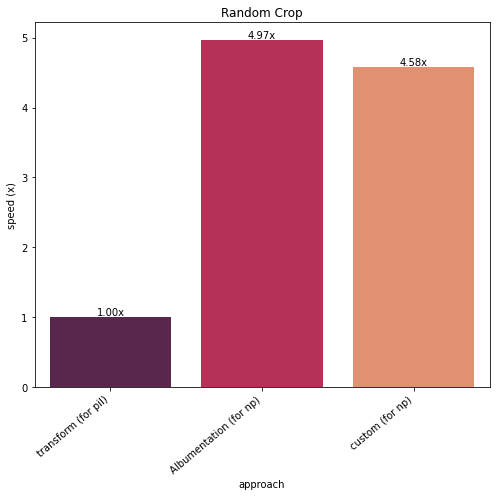

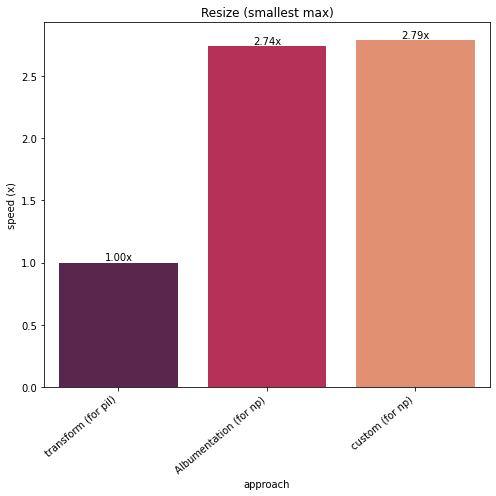

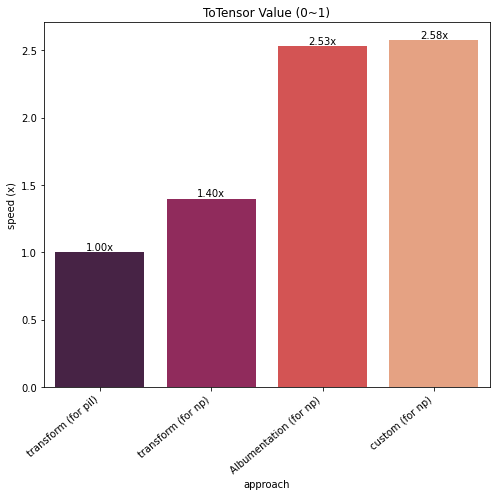

In [118]:
a = [["transform (for pil)", 33.7],
        ["Albumentation (for np)", 6.78],
        ["custom (for np)", 7.36]]

import pandas as pd
df = pd.DataFrame(a, columns=["approach", "speed (x)"])
df["speed (x)"] = df["speed (x)"].apply(lambda x: 33.7/x)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))

for i in df.index:
    word = df.loc[i, "speed (x)"]
    y = df.loc[i, "speed (x)"]
    plt.annotate(f"{word:.2f}x", (i, y), ha="center", va="bottom")
ax = sns.barplot(x="approach", y="speed (x)", data=df, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Random Crop")
plt.tight_layout()


a = [["transform (for pil)", 2.82],
        ["Albumentation (for np)", 1.03],
        ["custom (for np)", 1.01]]

df = pd.DataFrame(a, columns=["approach", "speed (x)"])
df["speed (x)"] = df["speed (x)"].apply(lambda x: 2.82/x)

plt.figure(figsize=(7, 7))

for i in df.index:
    word = df.loc[i, "speed (x)"]
    y = df.loc[i, "speed (x)"]
    plt.annotate(f"{word:.2f}x", (i, y), ha="center", va="bottom")
ax = sns.barplot(x="approach", y="speed (x)", data=df, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Resize (smallest max)")
plt.tight_layout()


a = [["transform (for pil)", 2.63],
        ["transform (for np)", 1.88],
        ["Albumentation (for np)", 1.04],
        ["custom (for np)", 1.02]]


df = pd.DataFrame(a, columns=["approach", "speed (x)"])
df["speed (x)"] = df["speed (x)"].apply(lambda x: 2.63/x)

plt.figure(figsize=(7, 7))

for i in df.index:
    word = df.loc[i, "speed (x)"]
    y = df.loc[i, "speed (x)"]
    plt.annotate(f"{word:.2f}x", (i, y), ha="center", va="bottom")
ax = sns.barplot(x="approach", y="speed (x)", data=df, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("ToTensor Value (0~1)")
plt.tight_layout()


## 測試3. approach to transfer image through network and then make model input well-prepared

* summary
        [['approach_io_np_t3', 3.908006429672241],
        ['approach_io_np_t2', 3.9259140491485596],
        ['approach_io_pil', 4.82680869102478],
        ['approach_wrap_io_pil', 4.844152450561523],
        ['approach_io_np_t1', 5.604491949081421],
        ['approach_wio_np_t3', 11.306720972061157],
        ['approach_wio_np_t2', 11.346932411193848],
        ['approach_b64_np_t2', 11.60984992980957],
        ['approach_b64_np_t3', 11.618371725082397],
        ['approach_wio_pil', 12.65789532661438],
        ['approach_b64_pil', 13.032054662704468],
        ['approach_wio_np_t1', 13.037485122680664],
        ['approach_b64_np_t1', 13.37218427658081]]


In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!wget https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg
import cv2
import numpy as np
from PIL import Image
from io import BufferedReader, BytesIO
import io
import os
import matplotlib.pyplot as plt
import base64
import time

import torch
import torch.nn as nn
from torchvision import models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# - - - - - - - - - - -
# approach 1: enc dec through base64
# - - - - - - - - - - -
def base64_enc(img):
    retval, jpg_enc_img = cv2.imencode(".jpg", img)
    return base64.b64encode(jpg_enc_img)

def dec_2_np_img(b64enc_img_bytes):
    img_bytes = base64.b64decode(b64enc_img_bytes)
    jpg_enc_img = np.frombuffer(img_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_enc_img, cv2.IMREAD_COLOR)

def dec_2_pil_img(b64enc_img_bytes):
    img_bytes = base64.b64decode(b64enc_img_bytes)
    return Image.open(io.BytesIO(img_bytes))

# - - - - - - - - - - -
# approach 2: pass open(, "rb") (io.BufferReader) directly
# - - - - - - - - - - -

# image_io = open("/content/Cat03.jpg", "rb")

# - - - - - - - - - - -
# approach 3: wrap loaded image using io (模仿2)
# - - - - - - - - - - -
def img_2_io_wrap_img(img):
    ret, jpg_enc_img = cv2.imencode('.jpg', img)
    img_bytes = jpg_enc_img.tobytes()		#将array转化为二进制类型
    io_bytes = BytesIO(img_bytes)		#转化为_io.BytesIO类型
    # io_bytes.name = "Cat03.jpg"		#名称赋值    
    return BufferedReader(io_bytes)		#转化为_io.BufferedReader类型

def io_wrap_img_2_np_img(image_io):
    img_bytes = image_io.read()
    image_buffer = np.frombuffer(img_bytes, dtype=np.uint8)
    return cv2.imdecode(image_buffer, cv2.IMREAD_COLOR)

def io_wrap_img_2_pil_img(image_io):
    img_bytes = image_io.read()    
    return Image.open(io.BytesIO(img_bytes))




# transformation
def transform_pil_img(pil_img):    
    comp_transfroms = transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.ToTensor()
                                    ])    
    return comp_transfroms(pil_img).unsqueeze(0)

def transform_1_np_img(np_img):
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    pil_img = Image.fromarray(np_img)
    comp_transfroms = transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.ToTensor()
                                    ])    
    return comp_transfroms(pil_img).unsqueeze(0)

def transform_2_np_img(np_img):
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    transform = A.Compose([      
                        A.Resize(224, 224),  # 變形                                                                             
                        ToTensorV2()
                ])
    return transform(image=np_img)['image'].div(255.0).unsqueeze(0)

def transform_3_np_img(np_img):
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
    np_img = cv2.resize(np_img, (224, 224))
    tensor = torch.tensor(np_img, dtype=torch.float)    
    return tensor.permute(2, 0, 1).div(255.0).unsqueeze(0)
    

     |████████████████████████████████| 98 kB 2.6 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
--2021-09-05 12:03:43--  https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279603 (273K) [image/jpeg]
Saving to: ‘Cat03.jpg.2’

Cat03.jpg.2         100%[===================>] 273.05K  1.32MB/s    in 0.2s    

2021-09-05 12:03:44 (1.32 MB/s) - ‘Cat03.jpg.2’ saved [279603/279603]



In [ ]:
def evaluate(func):
    start = time.time()
    for _ in range(100):
        model_input = func()
        if _ == 0:
            print(model_input)
    end = time.time()
    print(end - start)
    return end - start

# pil-1-b64
def approach_b64_pil():
    img = cv2.imread("/content/Cat03.jpg")
    enc_img = base64_enc(img)
    pil_img = dec_2_pil_img(enc_img)    
    return transform_pil_img(pil_img)

# pil-2-wrap-io
def approach_wio_pil():
    img = cv2.imread("/content/Cat03.jpg")
    image_io = img_2_io_wrap_img(img)
    pil_img = io_wrap_img_2_pil_img(image_io)    
    return transform_pil_img(pil_img)

# pil-3-io
def approach_io_pil():
    image_io = open("/content/Cat03.jpg", "rb")
    pil_img = io_wrap_img_2_pil_img(image_io)    
    return transform_pil_img(pil_img)


# np-b64-t1
def approach_b64_np_t1():
    img = cv2.imread("/content/Cat03.jpg")
    enc_img = base64_enc(img)
    np_img = dec_2_np_img(enc_img)    
    return transform_1_np_img(np_img)
 
# np-b64-t2
def approach_b64_np_t2():
    img = cv2.imread("/content/Cat03.jpg")
    enc_img = base64_enc(img)
    np_img = dec_2_np_img(enc_img)    
    return transform_2_np_img(np_img)

# np-b64-t3
def approach_b64_np_t3():
    img = cv2.imread("/content/Cat03.jpg")
    enc_img = base64_enc(img)
    np_img = dec_2_np_img(enc_img)    
    return transform_3_np_img(np_img)

# np-wio-t1
def approach_wio_np_t1():
    img = cv2.imread("/content/Cat03.jpg")
    image_io = img_2_io_wrap_img(img)
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_1_np_img(np_img)

# np-wio-t2
def approach_wio_np_t2():
    img = cv2.imread("/content/Cat03.jpg")
    image_io = img_2_io_wrap_img(img)
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_2_np_img(np_img)

# np-wio-t3
def approach_wio_np_t3():
    img = cv2.imread("/content/Cat03.jpg")
    image_io = img_2_io_wrap_img(img)
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_3_np_img(np_img)

# np-io-t1
def approach_io_np_t1():  
    image_io = open("/content/Cat03.jpg", "rb")
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_1_np_img(np_img)

# np-io-t2
def approach_io_np_t2():  
    image_io = open("/content/Cat03.jpg", "rb")
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_2_np_img(np_img)

# np-io-t3
def approach_io_np_t3():  
    image_io = open("/content/Cat03.jpg", "rb")
    np_img = io_wrap_img_2_np_img(image_io)
    return transform_3_np_img(np_img)

record = []
g = globals().copy()
for k, v in g.items():
    if "approach" in k:
        print(k)
        time_cost = evaluate(v)
        record.append([k, time_cost])
print(record)

approach_b64_pil
tensor([[[[0.8549, 0.8667, 0.8745,  ..., 0.9059, 0.9098, 0.9098],
          [0.8510, 0.8667, 0.8784,  ..., 0.9137, 0.9176, 0.9216],
          [0.8510, 0.8627, 0.8745,  ..., 0.9216, 0.9255, 0.9255],
          ...,
          [0.7373, 0.7451, 0.7333,  ..., 0.8588, 0.8627, 0.8549],
          [0.7373, 0.7451, 0.7373,  ..., 0.8706, 0.8745, 0.8706],
          [0.7333, 0.7333, 0.7333,  ..., 0.8745, 0.8784, 0.8824]],

         [[0.8196, 0.8314, 0.8431,  ..., 0.8784, 0.8745, 0.8706],
          [0.8157, 0.8314, 0.8471,  ..., 0.8824, 0.8784, 0.8667],
          [0.8235, 0.8353, 0.8510,  ..., 0.8745, 0.8667, 0.8549],
          ...,
          [0.6157, 0.6275, 0.6118,  ..., 0.8078, 0.8118, 0.8118],
          [0.6196, 0.6275, 0.6196,  ..., 0.8235, 0.8235, 0.8196],
          [0.6078, 0.6157, 0.6157,  ..., 0.8275, 0.8314, 0.8353]],

         [[0.6980, 0.7098, 0.7412,  ..., 0.8275, 0.8235, 0.8235],
          [0.6863, 0.7098, 0.7412,  ..., 0.8314, 0.8275, 0.8235],
          [0.6784, 0.7098

In [ ]:
sorted(record, key=lambda x:x[1])

[['approach_io_np_t3', 3.908006429672241],
 ['approach_io_np_t2', 3.9259140491485596],
 ['approach_io_pil', 4.82680869102478],
 ['approach_wrap_io_pil', 4.844152450561523],
 ['approach_io_np_t1', 5.604491949081421],
 ['approach_wio_np_t3', 11.306720972061157],
 ['approach_wio_np_t2', 11.346932411193848],
 ['approach_b64_np_t2', 11.60984992980957],
 ['approach_b64_np_t3', 11.618371725082397],
 ['approach_wio_pil', 12.65789532661438],
 ['approach_b64_pil', 13.032054662704468],
 ['approach_wio_np_t1', 13.037485122680664],
 ['approach_b64_np_t1', 13.37218427658081]]

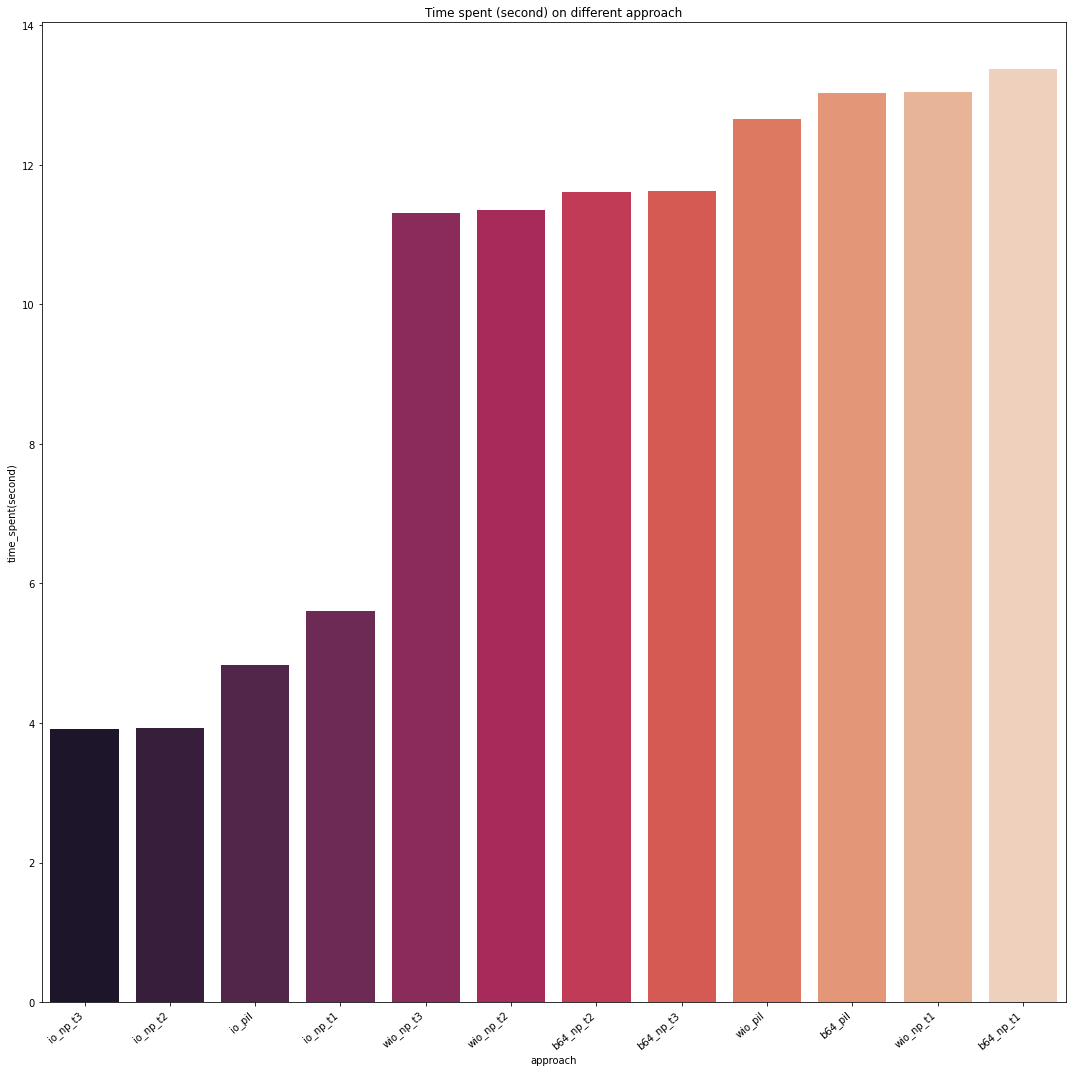

In [23]:
a =          [['approach_io_np_t3', 3.908006429672241],
          ['approach_io_np_t2', 3.9259140491485596],
          ['approach_io_pil', 4.82680869102478],
          ['approach_io_np_t1', 5.604491949081421],
          ['approach_wio_np_t3', 11.306720972061157],
          ['approach_wio_np_t2', 11.346932411193848],
          ['approach_b64_np_t2', 11.60984992980957],
          ['approach_b64_np_t3', 11.618371725082397],
          ['approach_wio_pil', 12.65789532661438],
          ['approach_b64_pil', 13.032054662704468],
          ['approach_wio_np_t1', 13.037485122680664],
          ['approach_b64_np_t1', 13.37218427658081]]
import pandas as pd
df = pd.DataFrame(a, columns=["approach", "time_spent(second)"])
df["approach"] = df["approach"].apply(lambda x: x.replace("approach_", ""))

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))

ax = sns.barplot(x="approach", y="time_spent(second)", data=df, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Time spent (second) on different approach")
plt.tight_layout()
